In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from skimage import color, exposure, feature, io
from sklearn.metrics import (ConfusionMatrixDisplay, auc, confusion_matrix,
                             f1_score, precision_score, recall_score, roc_curve)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

In [3]:
# Constants
BASE_DIR = r"D:\Documents\cnn\Data Set 1"
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
CLASS_NAMES = ['real', 'fake']

# Configure paths
data_paths = {
    'train': os.path.join(BASE_DIR, 'train'),
    'val': os.path.join(BASE_DIR, 'val'),
    'test': os.path.join(BASE_DIR, 'test')
}

In [4]:
# Data Generator Utilities
def create_data_generator(directory, augmentation=False, shuffle=True):
    if augmentation:
        datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode="nearest"
        )
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
        directory,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=shuffle,
        classes=CLASS_NAMES
    )

# Initialize data generators
train_gen = create_data_generator(data_paths['train'], augmentation=True)
val_gen = create_data_generator(data_paths['val'])
test_gen = create_data_generator(data_paths['test'], shuffle=False)

Found 40002 images belonging to 2 classes.
Found 12360 images belonging to 2 classes.
Found 5227 images belonging to 2 classes.


In [5]:
# Data Analysis Utilities
def get_class_distribution(directory):
    classes, counts = [], []
    for class_name in CLASS_NAMES:
        class_dir = os.path.join(directory, class_name)
        if os.path.exists(class_dir):
            counts.append(len(os.listdir(class_dir)))
            classes.append(class_name)
    return pd.DataFrame({'Class': classes, 'Count': counts})

def visualize_data_distribution():
    dfs = []
    for dataset in ['train', 'val', 'test']:
        df = get_class_distribution(data_paths[dataset])
        df['Dataset'] = dataset.capitalize()
        dfs.append(df)
    
    combined_df = pd.concat(dfs)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Class', y='Count', hue='Dataset', data=combined_df, palette='viridis')
    plt.title('Class Distribution Across Datasets')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [6]:
# Model Configuration
MODEL_CONFIGS = {
    'CustomCNN': {
        'layers': [
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*IMAGE_SIZE, 3)),
            layers.MaxPooling2D(2, 2),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D(2, 2),
            layers.Conv2D(128, (3, 3), activation='relu'),
            layers.MaxPooling2D(2, 2),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ]
    },
    'InceptionV3': {
        'base': InceptionV3(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3)),
        'top': [
            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ]
    },
    'MobileNetV2': {
        'base': MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3)),
        'top': [
            layers.GlobalAveragePooling2D(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(1, activation='sigmoid')
        ]
    }
}

In [7]:
def build_model(model_name):
    config = MODEL_CONFIGS[model_name]
    model = models.Sequential()
    
    if 'base' in config:
        model.add(config['base'])
        config['base'].trainable = False
    
    for layer in config.get('layers', []) + config.get('top', []):
        model.add(layer)
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )
    return model

In [8]:
# Training and Evaluation
def train_and_evaluate(models):
    histories, performances = {}, {}
    
    for model_name in models:
        model = build_model(model_name)
        print(f"Training {model_name}...")
        
        history = model.fit(
            train_gen,
            validation_data=val_gen,
            epochs=20,
            steps_per_epoch=train_gen.samples // BATCH_SIZE,
            validation_steps=val_gen.samples // BATCH_SIZE
        )
        
        # Evaluation
        test_pred = model.predict(test_gen).flatten()
        test_pred_classes = np.round(test_pred)
        
        performances[model_name] = {
            'accuracy': np.mean(test_pred_classes == test_gen.classes),
            'precision': precision_score(test_gen.classes, test_pred_classes),
            'recall': recall_score(test_gen.classes, test_pred_classes),
            'f1': f1_score(test_gen.classes, test_pred_classes),
            'roc_auc': auc(*roc_curve(test_gen.classes, test_pred)[:2])
        }
        
        histories[model_name] = history
        
        # Plotting
        plot_training_metrics(history, model_name)
        plot_confusion_matrix(test_gen.classes, test_pred_classes, model_name)
    
    return histories, performances

def plot_training_metrics(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=CLASS_NAMES)
    disp.plot(cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()


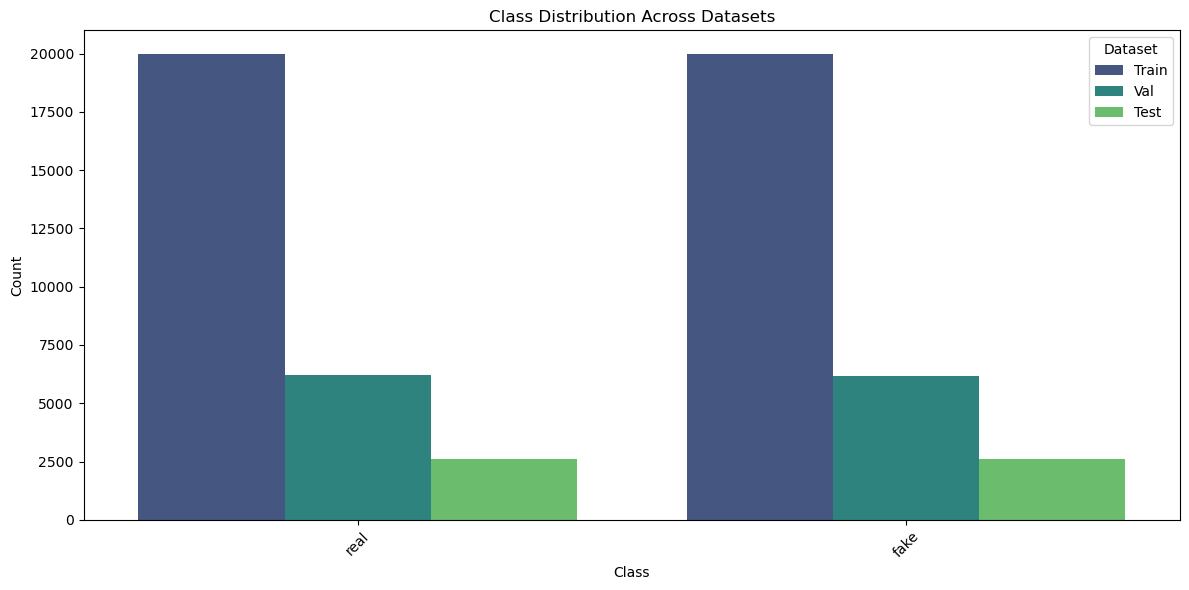

Training CustomCNN...
Epoch 1/20
1250/1250 [==============================] - 3711s 3s/step - loss: 0.6918 - accuracy: 0.5209 - precision: 0.5243 - recall: 0.4513 - val_loss: 0.6603 - val_accuracy: 0.6129 - val_precision: 0.6357 - val_recall: 0.5229
Epoch 2/20
1250/1250 [==============================] - 2216s 2s/step - loss: 0.6635 - accuracy: 0.6025 - precision: 0.6169 - recall: 0.5411 - val_loss: 0.6363 - val_accuracy: 0.6496 - val_precision: 0.6065 - val_recall: 0.8464
Epoch 3/20
1250/1250 [==============================] - 1707s 1s/step - loss: 0.6326 - accuracy: 0.6449 - precision: 0.6580 - recall: 0.6035 - val_loss: 0.5732 - val_accuracy: 0.7013 - val_precision: 0.6424 - val_recall: 0.9039
Epoch 4/20
1250/1250 [==============================] - 1717s 1s/step - loss: 0.5549 - accuracy: 0.7235 - precision: 0.7303 - recall: 0.7086 - val_loss: 0.4672 - val_accuracy: 0.7785 - val_precision: 0.7273 - val_recall: 0.8889
Epoch 5/20
1250/1250 [==============================] - 1711s 1s/s

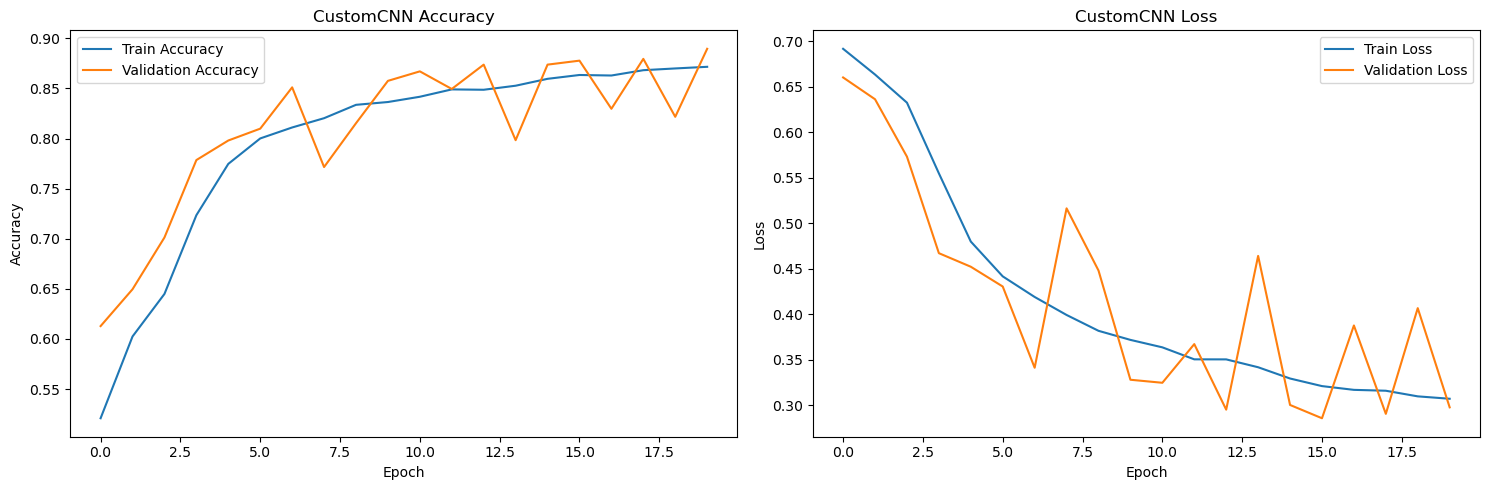

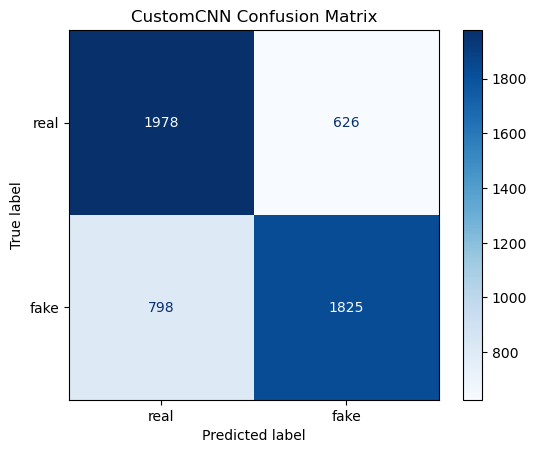

Training InceptionV3...
Epoch 1/20
1250/1250 [==============================] - 3242s 3s/step - loss: 0.6158 - accuracy: 0.6667 - precision: 0.6779 - recall: 0.6351 - val_loss: 0.5208 - val_accuracy: 0.7431 - val_precision: 0.7117 - val_recall: 0.8147
Epoch 2/20
1250/1250 [==============================] - 2514s 2s/step - loss: 0.5736 - accuracy: 0.6976 - precision: 0.7169 - recall: 0.6532 - val_loss: 0.5208 - val_accuracy: 0.7447 - val_precision: 0.7021 - val_recall: 0.8468
Epoch 3/20
1250/1250 [==============================] - 1898s 2s/step - loss: 0.5680 - accuracy: 0.7020 - precision: 0.7268 - recall: 0.6473 - val_loss: 0.4963 - val_accuracy: 0.7634 - val_precision: 0.7318 - val_recall: 0.8291
Epoch 4/20
 685/1250 [===============>..............] - ETA: 10:13 - loss: 0.5610 - accuracy: 0.7073 - precision: 0.7253 - recall: 0.6727

In [ ]:
# Main Execution
if __name__ == "__main__":
    visualize_data_distribution()
    model_histories, model_performances = train_and_evaluate(MODEL_CONFIGS.keys())
    
    # Performance comparison
    pd.DataFrame(model_performances).T.plot(kind='bar', figsize=(12, 6))
    plt.title('Model Performance Comparison')
    plt.xticks(rotation=45)
    plt.ylabel('Score')
    plt.tight_layout()
    plt.show()